In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from utils.utils import pretty_lat, pretty_lon, ProgressStatus, plot_n_steps_of_area_from_nc_file
from tempfile import TemporaryDirectory

In [2]:
from station.data_submission import DataSubmission
from station.station import StationData

from train_station_twin.training_executer import TrainingExecuter
from infilling.evaluation_executer import EvaluationExecuter
from infilling.infilling_writer import InfillingWriter

from era5.era5_for_station import DownloadEra5ForStation, DownloadEra5ForStationGaps
from era5.era5_download_hook import Era5DownloadHook
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


In [18]:
era5_hook = Era5DownloadHook(lat=0, lon=0)
era5_hook.coordinate_limits = {
    "north": 14.16443,
    "south": 12.16443,
    "west": -60.543,
    "east": -58.543
}

date = pd.Timestamp("2020-06-23")
folder = tempfile.TemporaryDirectory()
era5_target_file_path = f"{folder.name}/era5.nc"
era5_hook.download_hours_in_same_day(
    year=date.year,
    month=date.month,
    day=date.day,
    hours=[18,19,20],
    target_folder=folder.name
)
    

2024-05-05 20:58:36,836 INFO Welcome to the CDS
2024-05-05 20:58:36,837 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-05-05 20:58:36,975 INFO Request is queued
2024-05-05 20:58:38,042 INFO Request is running
2024-05-05 20:58:39,599 INFO Request is completed
2024-05-05 20:58:39,599 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data3/adaptor.mars.internal-1714935517.226986-8965-7-8c99658a-a230-4de4-8cee-5da2e2e2a736.grib to /var/folders/yj/k7pg73d56rl366r8bvlbncgm0000gn/T/tmp4010p9nz/2020_6_23.grib (810)
2024-05-05 20:58:40,076 INFO Download rate 1.7K/s


Found 2020_6_23.grib
Renamed variable var167 to tas in /var/folders/yj/k7pg73d56rl366r8bvlbncgm0000gn/T/tmp_ppwl3t5/2020_6_23.nc
Found 2020_6_23.nc
Merged era5 file saved into /var/folders/yj/k7pg73d56rl366r8bvlbncgm0000gn/T/tmp4010p9nz/era5.nc
<xarray.Dataset> Size: 4kB
Dimensions:  (time: 12, lon: 9, lat: 9)
Coordinates:
  * time     (time) datetime64[ns] 96B 2020-06-23T18:00:00 ... 2020-06-23T20:...
  * lon      (lon) float64 72B 299.5 299.7 300.0 300.2 ... 301.0 301.2 301.5
  * lat      (lat) float64 72B 14.17 13.91 13.66 13.41 ... 12.66 12.41 12.16
Data variables:
    tas      (time, lat, lon) float32 4kB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Sun May 05 20:58:40 2024: cdo cat /var/folders/yj/k7pg73d56...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...


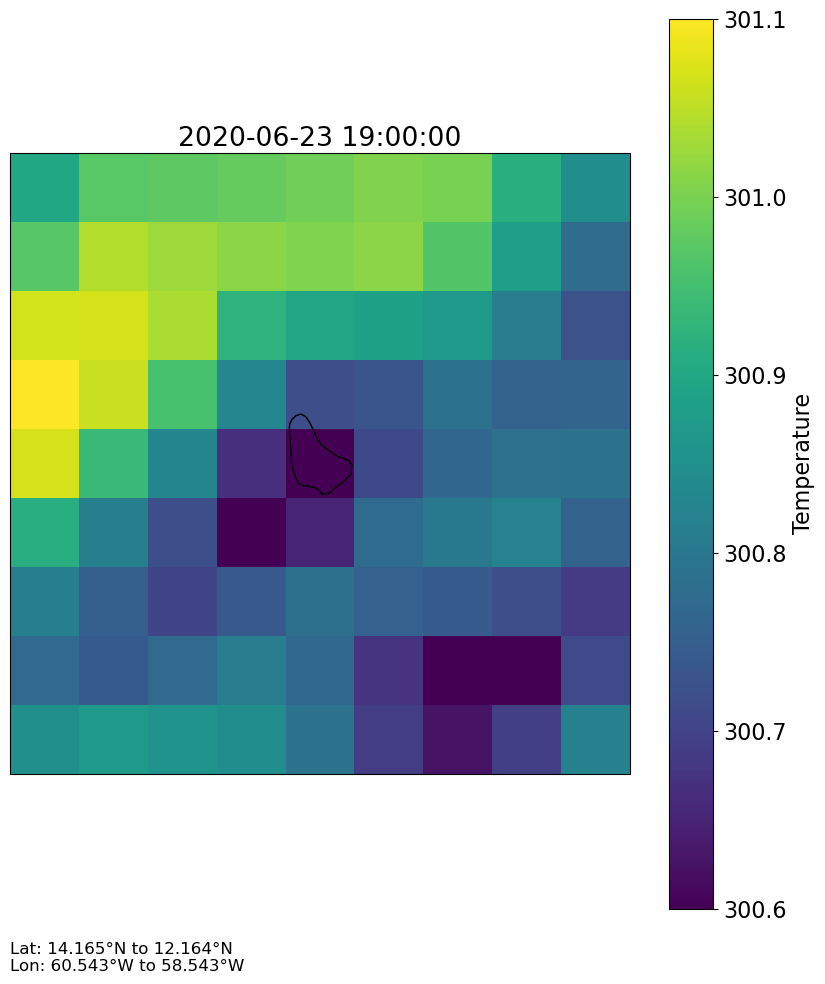

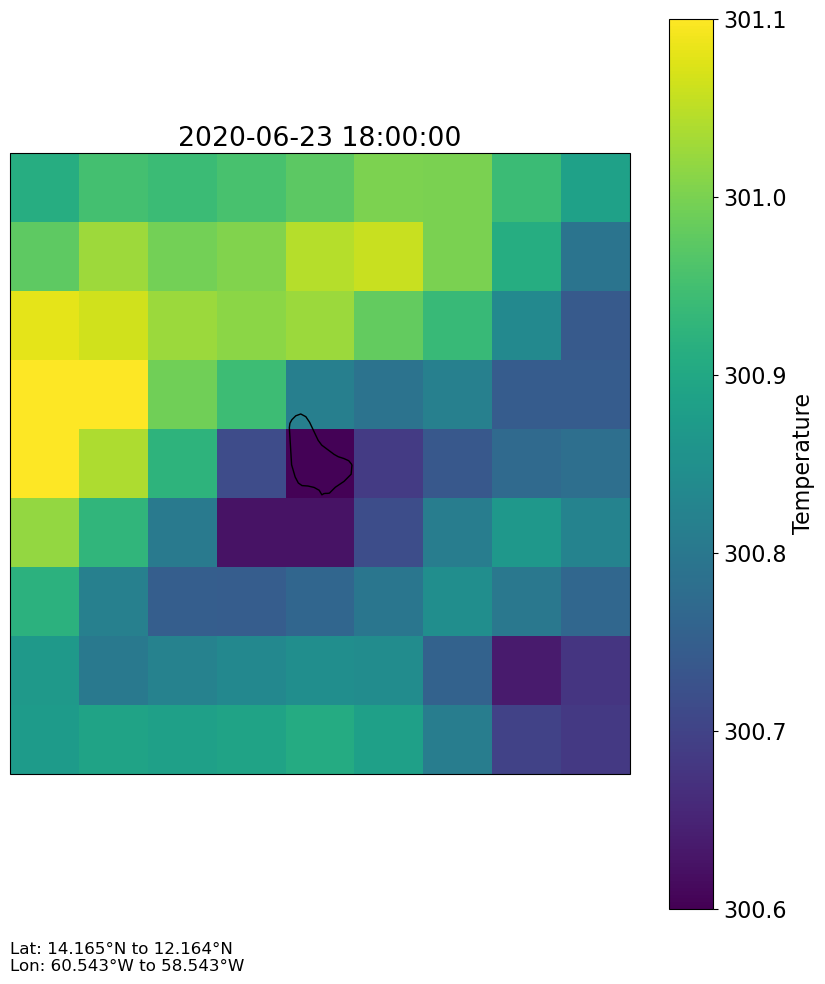

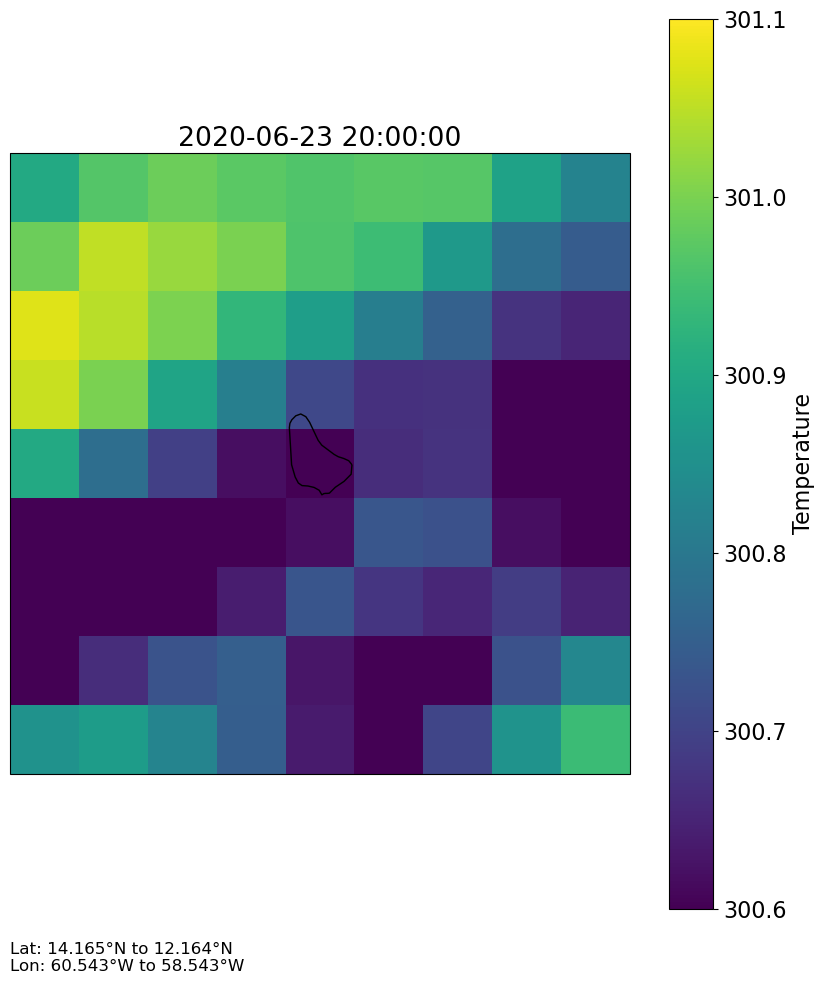

array([4, 6, 2])

In [22]:
from era5.era5_from_grib_to_nc import Era5DataFromGribToNc

# conversion
Era5DataFromGribToNc(
    folder_path=folder.name,
    era5_target_file_path=era5_target_file_path
)

print(xr.open_dataset(era5_target_file_path))

# plot the data
plot_n_steps_of_area_from_nc_file(
    path=era5_target_file_path,
    n=3,
    vars="tas",
    title="ERA5 temperature",
    vmin=300.6,
    vmax=301.1
)

In [5]:
barbados_data = DataSubmission("Barbados")
barbados_data.measurement_dir_path = "./measurements/Barbados/"

barbados_station = StationData(
    name=barbados_data.name,
    folder_path=barbados_data.measurement_dir_path
)

Extracting Barbados...


100%|██████████| 1263/1263 [01:13<00:00, 17.09it/s]


In [6]:
# start date
start_date = "2020-01-01"
# end date
end_date = "2020-12-31"

# slice the df barbados_station.df
df = barbados_station.df.loc[start_date:end_date]
df

,ir_light,vis_light,tas,uv_light
datetime,,,,
2020-06-23 18:00:00,5135.344828,716.931034,301.148276,246.517241
2020-06-23 19:00:00,2969.266667,512.883333,299.438333,137.083333
2020-06-23 20:00:00,2080.833333,427.733333,299.860000,91.516667
2020-06-23 21:00:00,839.716667,314.633333,299.188333,30.900000
2020-06-23 22:00:00,315.800000,266.316667,298.666667,5.100000
...,...,...,...,...
2020-12-31 19:00:00,2856.783333,511.050000,299.880769,136.116667
2020-12-31 20:00:00,1277.741379,360.931034,298.935714,55.637931
2020-12-31 21:00:00,459.116667,279.233333,298.241667,11.950000


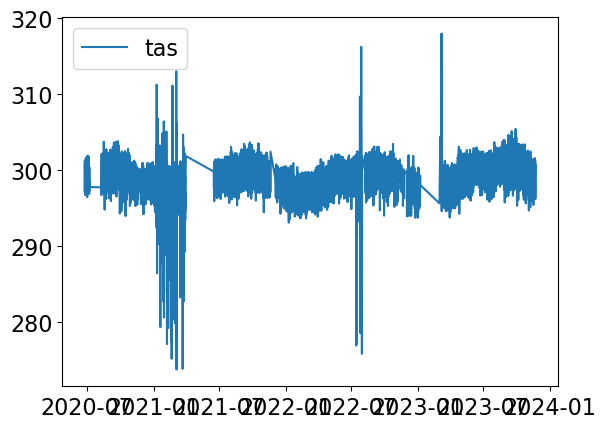

In [7]:

from utils.utils import plot_measurements_df
plot_measurements_df(barbados_station.df)

**Plot a few random timesteps of the weather station:**

In [8]:
marshall_station = StationData("Marshall", "./measurements/Marshall/")
vienna_station = StationData("Vienna", "./measurements/Vienna/")

Extracting Marshall...


 91%|█████████ | 2248/2465 [02:11<00:12, 17.14it/s]


KeyboardInterrupt: 

In [ ]:
st = "executed_trainings/Vienna_20240522-1659/target_9gs0g5n6/train/vienna.nc"
e5 = "executed_trainings/Vienna_20240522-1659/target_9gs0g5n6/train/era5_merged.nc"

dst = xr.open_dataset(st)
de5 = xr.open_dataset(e5)

plt.plot(station_submission.station.df.index, station_submission.station.df["tas"], label="station")
plt.plot(de5["time"], de5["tas"].mean(axis=(1,2)), label="era5")